<a href="https://colab.research.google.com/github/Jack-The-Ripper-1820/GAN_VAE/blob/main/MNIST_GAN_VAE_ver2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import tensorflow as tf
import os
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras.layers import Input, Dense, Lambda, Reshape, Conv2DTranspose, Flatten
from keras.models import Model
from keras.losses import BinaryCrossentropy

In [4]:
# Define the generator network

def make_generator_model():
    latent_dim = 100
    model = keras.Sequential(name = 'Generator')
    model.add(layers.Dense(7 * 7 * 256, use_bias = False, input_shape = (latent_dim, )))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
      
    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias = False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias = False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias = False))
    assert model.output_shape == (None, 28, 28, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides = (2, 2), padding = 'same', use_bias = False, activation = 'tanh'))
    assert model.output_shape == (None, 56, 56, 1)

    return model

In [5]:
# Define the discriminator network
def make_discriminator_model():
    model = keras.Sequential(name = 'Discriminator')
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[56, 56, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [6]:
# Define the loss functions
cross_entropy = BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [7]:
#Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.reshape(-1, 56, 56, 1).astype('float32')
x_train = (x_train - 127.5) / 127.5

In [8]:
#Create the generator and discriminator models
generator = make_generator_model()
discriminator = make_discriminator_model()

generator.summary()
discriminator.summary()
#Define the optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

#Define a checkpoint to save the model weights
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
discriminator_optimizer=discriminator_optimizer, generator=generator, discriminator=discriminator)

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        51

Epoch:  0
Discriminator loss:  tf.Tensor(0.82668364, shape=(), dtype=float32)
Generator loss:  tf.Tensor(2.329428, shape=(), dtype=float32)


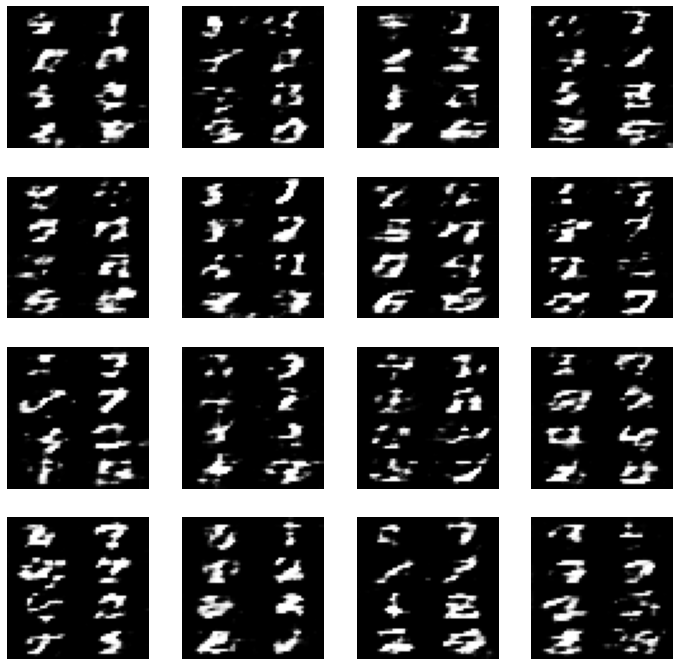

Epoch:  10
Discriminator loss:  tf.Tensor(0.6465468, shape=(), dtype=float32)
Generator loss:  tf.Tensor(2.7861867, shape=(), dtype=float32)
Epoch:  20
Discriminator loss:  tf.Tensor(0.34856537, shape=(), dtype=float32)
Generator loss:  tf.Tensor(3.3438883, shape=(), dtype=float32)
Epoch:  30
Discriminator loss:  tf.Tensor(0.4706518, shape=(), dtype=float32)
Generator loss:  tf.Tensor(3.2787864, shape=(), dtype=float32)


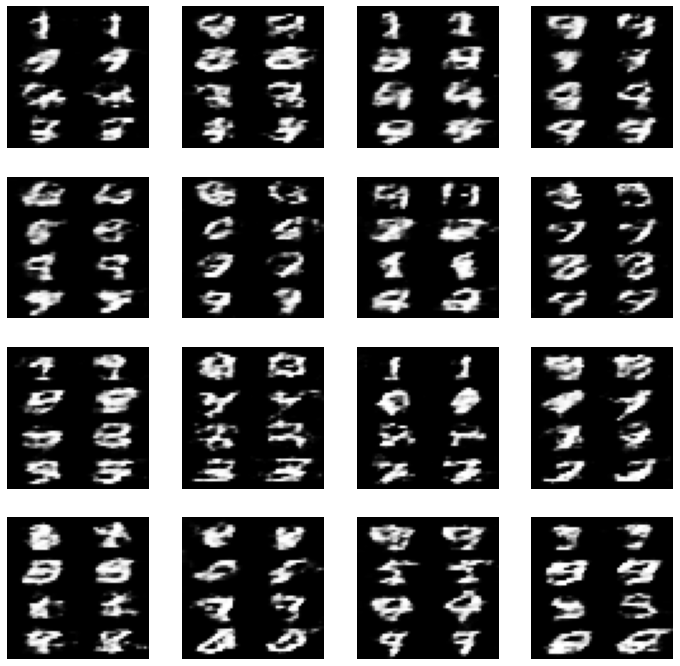

Epoch:  40
Discriminator loss:  tf.Tensor(0.40260804, shape=(), dtype=float32)
Generator loss:  tf.Tensor(3.9087925, shape=(), dtype=float32)


In [15]:
#Train the GAN
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16
BATCH_SIZE = 32 
seed = tf.random.normal([num_examples_to_generate, noise_dim])
noise = tf.random.normal([BATCH_SIZE, noise_dim])

for epoch in range(EPOCHS):
  for i in range(len(x_train) // BATCH_SIZE):
    # Get a batch of real images
    start = i * BATCH_SIZE
    end = (i + 1) * BATCH_SIZE
    real_images = x_train[start:end]
    # Generate a batch of fake images
    
    fake_images = generator(noise, training=True)
    # print(fake_images[0].shape)
    # Train the discriminator
    with tf.GradientTape() as disc_tape:
        real_output = discriminator(real_images, training=True)
        fake_output = discriminator(fake_images, training=True)
        disc_loss = discriminator_loss(real_output, fake_output)
    grads = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))

    # Train the generator
    with tf.GradientTape() as gen_tape:
        fake_images = generator(noise, training=True)
        fake_output = discriminator(fake_images, training=True)
        gen_loss = generator_loss(fake_output)
    grads = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(grads, generator.trainable_variables))

  # Print the loss values for every 10 epochs
  if epoch % 10 == 0:
      print("Epoch: ", epoch)
      print("Discriminator loss: ", disc_loss)
      print("Generator loss: ", gen_loss)
  # Save the model weights every 20 epochs
  if epoch % 20 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

  # Generate and plot some fake images every 30 epochs
  if epoch % 30 == 0:
      fake_images = generator(seed, training=False)
      plt.figure(figsize=(12, 12))
      for i in range(num_examples_to_generate):
          plt.subplot(4, 4, i + 1)
          plt.imshow(tf.reshape(fake_images[i], (56, 56)), cmap='gray')
          plt.axis('off')
      plt.show()


Average prediction: -6.7862377


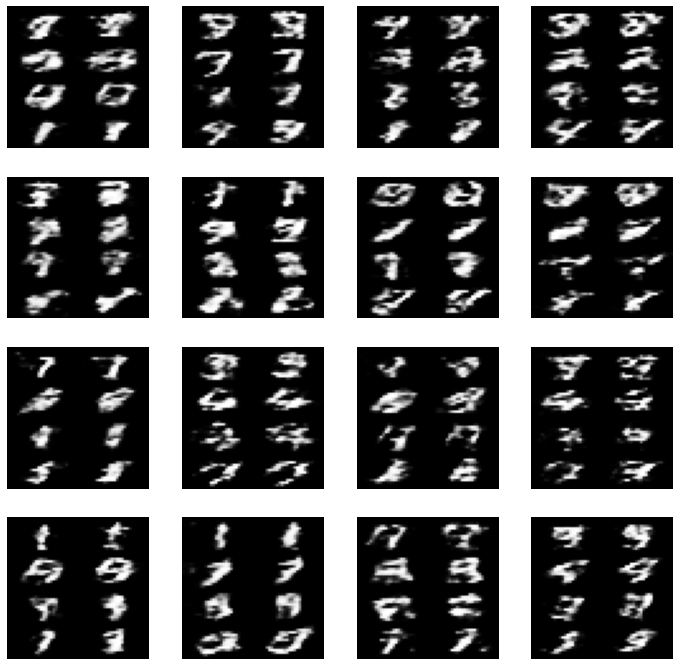

In [17]:
fake_images = generator(seed, training=False)
predictions = discriminator(fake_images, training = False)
average_prediction = tf.reduce_mean(predictions)
print("Average prediction:", average_prediction.numpy())
plt.figure(figsize=(12, 12))

for i in range(num_examples_to_generate):
  plt.subplot(4, 4, i + 1)
  plt.imshow(tf.reshape(fake_images[i], (56, 56)), cmap='gray')
  plt.axis('off')
plt.show()